#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Задача - построить модель для такого предсказания.

По заданию значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка данных

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


In [10]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Прежде, чем делать ресемплирование, проверим столбец num_orders на последовательность и отсутствие пропусков:

In [11]:
df.index.is_monotonic

True

Некорректных значений нет, можем выполнить операцию:

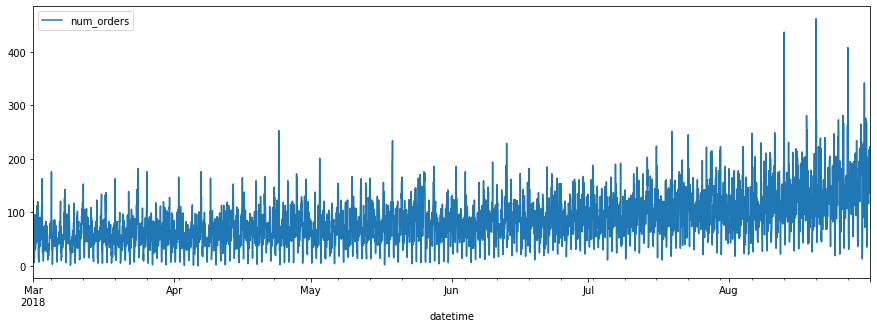

In [12]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.plot(figsize=(15, 5));

Определим функцию, которая выделит необходимые для исследования признаки - столбцы с предыдущими значениями временного ряда, скользящее среднее, а также день недели и час. Год не понадобится, тк данные представлены только за 2018 год.

In [13]:
def make_features(data, max_lag):
    
    data['dayofweek'] = data.index.dayofweek
    
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()

make_features(df, 24)

## Анализ

Посмотрим на распределение заказов по часам за все время наблюдений:

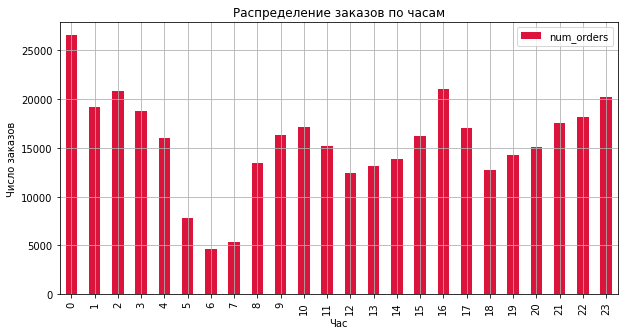

In [14]:
df.pivot_table(['num_orders'], ['hour'], aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 5), color='crimson')
plt.title('Распределение заказов по часам')
plt.xlabel('Час')
plt.ylabel('Число заказов');

Самый пиковый час - полночь, затем 2 и 16 часов. Наименьшее кол-во заказов происходит с 5 до 7 утра.

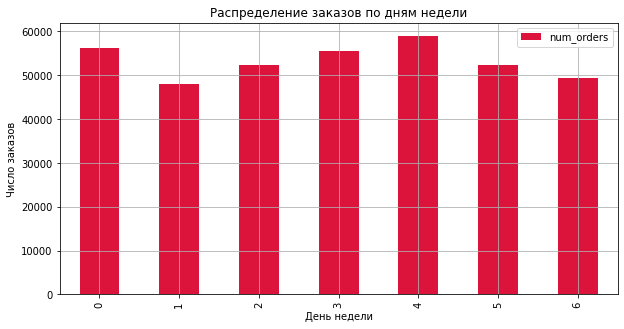

In [15]:
df.pivot_table(['num_orders'], ['dayofweek'], aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 5), color='crimson')
plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число заказов');

По дням недели пиковые дни - пятница и понедельник.

Посмотрим на графики тренда и сезонности:

In [16]:
decomposed = seasonal_decompose(df['num_orders'])

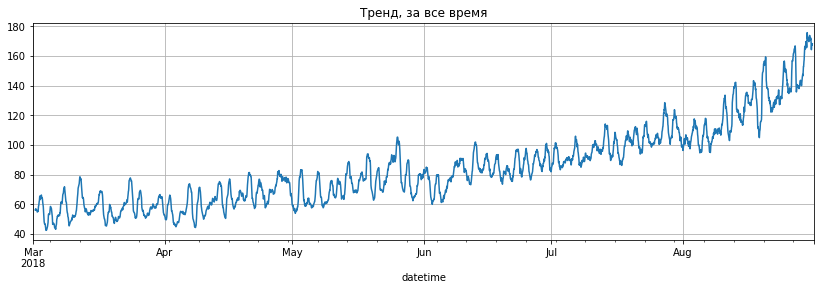

In [17]:
decomposed.trend.plot(grid=True ,ax=plt.gca(), figsize=(14, 4))
plt.title('Тренд, за все время');

Видим восходящий тренд за все время наблюдений.

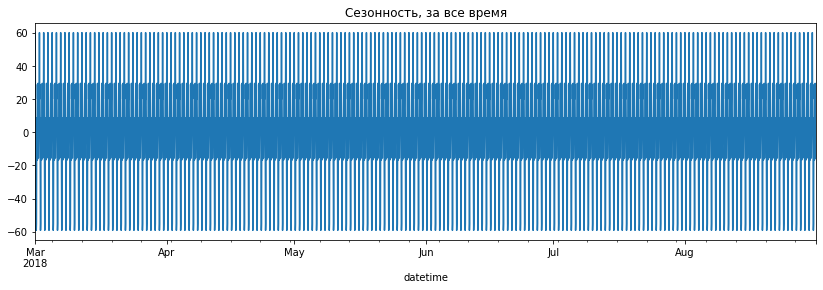

In [18]:
decomposed.seasonal.plot(ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, за все время');

График сезонности за все время не дает ясной картины, поэтому рассмотрим данные на меньшем промежутке, за три последних дня:

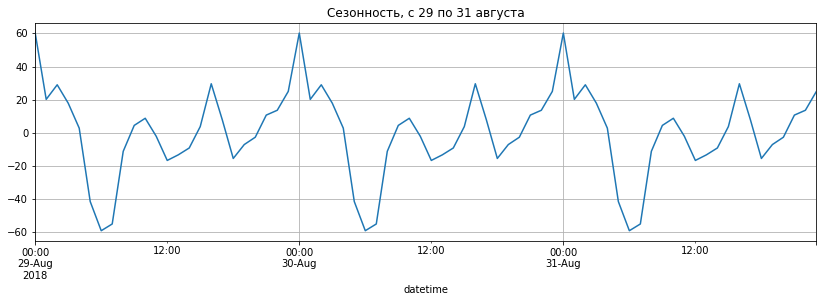

In [19]:
decomposed.seasonal['2018-08-29':'2018-08-31'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, с 29 по 31 августа');

Для сравнения возьмем такой же трехдневный промежуток, но в середине мая:

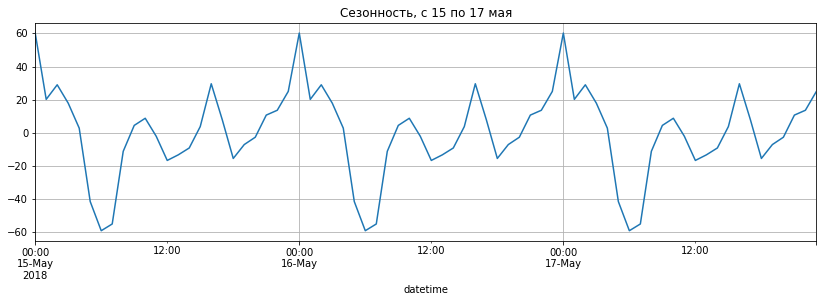

In [20]:
decomposed.seasonal['2018-05-15':'2018-05-17'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, с 15 по 17 мая');

Графики идентичны, поэтому можем сказать, что сезонность не зависит от тренда.

Рассмотрим один день:

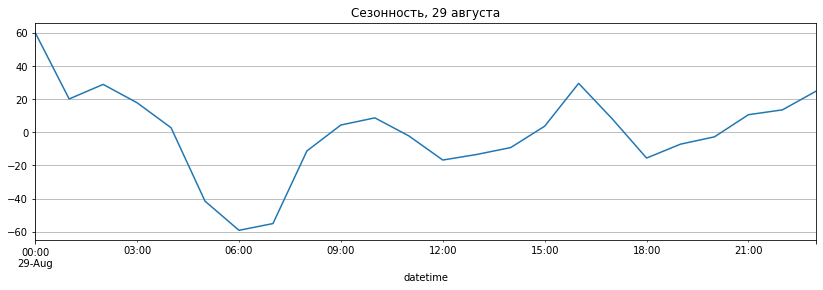

In [21]:
decomposed.seasonal['2018-08-29':'2018-08-29'].plot(grid=True, ax=plt.gca(),figsize=(14, 4))
plt.title('Сезонность, 29 августа');

Пик заказов приходится на полночь, минимум - на 6 утра.

## Обучение

Разделим данные на выборки, под тестовую выборку выделим 10%:

In [22]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Выделим признаки и целевой признак:

In [23]:
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

Определим функцию для обучения моделей и вычиления RMSE:

In [24]:
def model_cv(model, param_grid, n_split):
    tscv = TimeSeriesSplit(n_splits=n_split)
    grid = GridSearchCV(model, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=False)
    grid.fit(X_train, y_train)
    rmse = round(abs(grid.best_score_), 3)
    print('RMSE на обучающей выборке:', rmse) 
    return rmse

### Линейная регрессия

In [17]:
model = LinearRegression()
rmse_lr = round(abs(cross_val_score(model, X_train, y_train, 
                         cv = TimeSeriesSplit(n_splits=8), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()), 3)
print('RMSE на обучающей выборке:', rmse_lr)

RMSE на обучающей выборке: 26.625


### Дерево решений

In [18]:
params =  {'max_depth': range (1, 13, 2),
           'min_samples_leaf': range (1, 8),
           'min_samples_split': range (2, 10, 2)}

rmse_dt = model_cv(DecisionTreeRegressor(), params, 8)

RMSE на обучающей выборке: 29.016


### Случайный лес

In [19]:
params =  {'n_estimators': range(100, 155, 15),
           'max_depth': range (5, 15, 5)}
rmse_rf = model_cv(RandomForestRegressor(), params, 8)

RMSE на обучающей выборке: 24.517


### CatBoost

In [20]:
params =  {'depth': range (7,11, 2),
           'learning_rate': (0.03, 0.1)}

rmse_cb = model_cv(CatBoostRegressor(verbose=False), params, 8)

RMSE на обучающей выборке: 23.58


## Результаты

Объединим полученные результаты в одну таблицу:

In [21]:
results = pd.DataFrame([
    [rmse_lr],
    [rmse_dt],
    [rmse_rf],
    [rmse_cb]], 
    columns=['RMSE'],
    index=['LinearRegression', 'DecisionTree', 'RandomForest', 'CatBoost'])

results.sort_values(by='RMSE')

,RMSE
CatBoost,23.580
RandomForest,24.517
LinearRegression,26.625
DecisionTree,29.016


Результаты оценки качества для всех моделей входят в заданное значение 48, лучший результат RMSE показывает CatBoost, худший результат у модели решающего дерева.

## Тестирование

Проверим наилучшую модель CatBoost на тестовой выборке:

In [25]:
model = CatBoostRegressor(verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = round(mean_squared_error(y_test, y_pred)**0.5, 3)

print('RMSE на тестовой выборке:', rmse)

RMSE на тестовой выборке: 40.754


Значение RMSE для CatBoost на тестовой выборке входит в заданное значение 48.

Далее на графике сравним реальные и предсказанные значения:

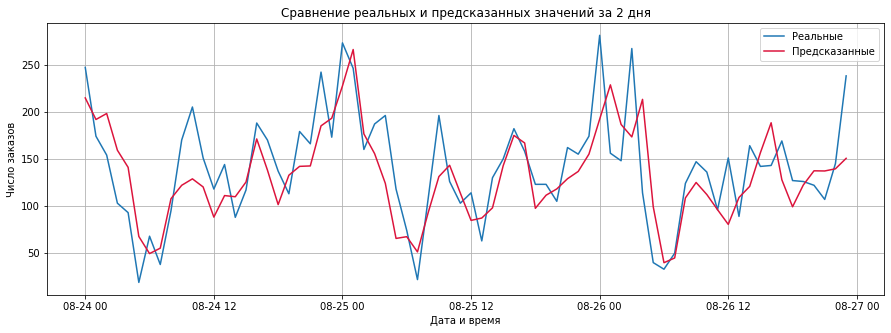

In [28]:
y_pred = pd.Series(y_pred, index=y_test.index)
plt.figure(figsize=(15, 5))
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.plot(y_test['2018-08-24':'2018-08-26'], label='Реальные')
plt.plot(y_pred['2018-08-24':'2018-08-26'], label='Предсказанные', color='crimson')
plt.title('Cравнение реальных и предсказанных значений за 2 дня')
plt.legend();
plt.grid(True)

На графике можно увидеть, что в спокойные часы модель предсказывает неплохо, тогда как в пиковые часы ошибается достаточно сильно.

## Вывод

По результатам исследования можно рекомендовать модель CatBoost как наиболее оптимальный вариант для решения задачи прогнозирования заказов такси на ближайший час.